In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from docplex.cp.model import  CpoModel
import docplex.cp.utils_visu as visu

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

import sys
sys.path.append("..")
from utils import extract_solution

# Example 1

Source: Serge Kruk : Practical Python AI Projects, Mathematical Models of Mathematical Models of Google OR-Tools

![alternatvie text](../pics/2023-08-02-15-54-00.png)

In [2]:
data = [("J0", (1,10), (2,10), (0,10)),
        ("J1", (1,5), (0,8), (2,5)),
        ("J2", (2,5), (1,9), (0,9)),
        ("J3", (0,6), (2,9), (1,5))]

Jobs = []   

for i in data:
    job = i[0]
    for j in i[1:4]:
        machine = j[0]
        duration = j[1]
        Jobs = Jobs + [[job, machine , duration]]



jobs_data = pd.DataFrame(Jobs, columns = ['job', 'machine' , 'duration'] )


jobs_data['order'] = 'x'
for i in jobs_data['job'].unique():
    jobs_data.loc[jobs_data['job']==i, 'order'] = range(1,4)
jobs_data

,job,machine,duration,order
0,J0,1,10,1
1,J0,2,10,2
2,J0,0,10,3
3,J1,1,5,1
4,J1,0,8,2
5,J1,2,5,3
6,J2,2,5,1
7,J2,1,9,2
8,J2,0,9,3
9,J3,0,6,1


In [3]:
horizon = jobs_data['duration'].sum()
#horizon=40

In [4]:
mdl = CpoModel(name="JobScheduling")

DV=[]
for row in jobs_data.itertuples():

    dv = mdl.interval_var(size  =  row.duration, end = [0, horizon], name='%s_Machine%s'%(row.job, row.machine  ))# ,  , 
    DV.append(dv) 
jobs_data['DV'] = DV
jobs_data

,job,machine,duration,order,DV
0,J0,1,10,1,"J0_Machine1 = intervalVar(end=0..91, size=10)"
1,J0,2,10,2,"J0_Machine2 = intervalVar(end=0..91, size=10)"
2,J0,0,10,3,"J0_Machine0 = intervalVar(end=0..91, size=10)"
3,J1,1,5,1,"J1_Machine1 = intervalVar(end=0..91, size=5)"
4,J1,0,8,2,"J1_Machine0 = intervalVar(end=0..91, size=8)"
5,J1,2,5,3,"J1_Machine2 = intervalVar(end=0..91, size=5)"
6,J2,2,5,1,"J2_Machine2 = intervalVar(end=0..91, size=5)"
7,J2,1,9,2,"J2_Machine1 = intervalVar(end=0..91, size=9)"
8,J2,0,9,3,"J2_Machine0 = intervalVar(end=0..91, size=9)"
9,J3,0,6,1,"J3_Machine0 = intervalVar(end=0..91, size=6)"


In [5]:
precedence_list = []
for job in jobs_data['job'].unique():
    u= jobs_data[jobs_data['job']==job]
    order_list = u['order'].values
    precedence = [[a,b] for a in order_list for b in order_list if a<b]


    for i in precedence:
        first_Task = u[u['order']==i[0]]['DV'].values[0]
        second_Task = u[u['order']==i[1]]['DV'].values[0]
        print("The task ", first_Task , '   should be before   ', second_Task)

        mdl.add( mdl.end_before_start(first_Task  , second_Task ))

The task  J0_Machine1 = intervalVar(end=0..91, size=10)    should be before    J0_Machine2 = intervalVar(end=0..91, size=10)
The task  J0_Machine1 = intervalVar(end=0..91, size=10)    should be before    J0_Machine0 = intervalVar(end=0..91, size=10)
The task  J0_Machine2 = intervalVar(end=0..91, size=10)    should be before    J0_Machine0 = intervalVar(end=0..91, size=10)
The task  J1_Machine1 = intervalVar(end=0..91, size=5)    should be before    J1_Machine0 = intervalVar(end=0..91, size=8)
The task  J1_Machine1 = intervalVar(end=0..91, size=5)    should be before    J1_Machine2 = intervalVar(end=0..91, size=5)
The task  J1_Machine0 = intervalVar(end=0..91, size=8)    should be before    J1_Machine2 = intervalVar(end=0..91, size=5)
The task  J2_Machine2 = intervalVar(end=0..91, size=5)    should be before    J2_Machine1 = intervalVar(end=0..91, size=9)
The task  J2_Machine2 = intervalVar(end=0..91, size=5)    should be before    J2_Machine0 = intervalVar(end=0..91, size=9)
The task  

In [6]:
jobs_data.loc[:,'endtime']=jobs_data['DV'].apply(lambda x:mdl.end_of(x))
jobs_data

,job,machine,duration,order,DV,endtime
0,J0,1,10,1,"J0_Machine1 = intervalVar(end=0..91, size=10)",endOf(J0_Machine1)
1,J0,2,10,2,"J0_Machine2 = intervalVar(end=0..91, size=10)",endOf(J0_Machine2)
2,J0,0,10,3,"J0_Machine0 = intervalVar(end=0..91, size=10)",endOf(J0_Machine0)
3,J1,1,5,1,"J1_Machine1 = intervalVar(end=0..91, size=5)",endOf(J1_Machine1)
4,J1,0,8,2,"J1_Machine0 = intervalVar(end=0..91, size=8)",endOf(J1_Machine0)
5,J1,2,5,3,"J1_Machine2 = intervalVar(end=0..91, size=5)",endOf(J1_Machine2)
6,J2,2,5,1,"J2_Machine2 = intervalVar(end=0..91, size=5)",endOf(J2_Machine2)
7,J2,1,9,2,"J2_Machine1 = intervalVar(end=0..91, size=9)",endOf(J2_Machine1)
8,J2,0,9,3,"J2_Machine0 = intervalVar(end=0..91, size=9)",endOf(J2_Machine0)
9,J3,0,6,1,"J3_Machine0 = intervalVar(end=0..91, size=6)",endOf(J3_Machine0)


In [7]:
all_machines = jobs_data['machine'].unique()

for i in all_machines:
    u= jobs_data[jobs_data['machine']==i]
    
    print(  [k.name for k in  u['DV'].values.tolist()], "  shouldn't overlap")
    mdl.add ( mdl.no_overlap(  u['DV'].values.tolist()))


['J0_Machine1', 'J1_Machine1', 'J2_Machine1', 'J3_Machine1']   shouldn't overlap
['J0_Machine2', 'J1_Machine2', 'J2_Machine2', 'J3_Machine2']   shouldn't overlap
['J0_Machine0', 'J1_Machine0', 'J2_Machine0', 'J3_Machine0']   shouldn't overlap


In [8]:
obj = mdl.minimize ( mdl.max ( jobs_data['endtime']) )

mdl.add(obj)

msol = mdl.solve(TimeLimit=50)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 15 variables, 15 constraints
 ! TimeLimit            = 50
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 43.0 (before), 43.0 (after)
 !  . Memory usage      : 441.7 kB (before), 441.7 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         15                 -
 + New bound is 30
 ! Using iterative diving.
 *            43       25  0.04s        1      (gap is 30.23%)
 *            42       49  0.04s        1      (gap is 28.57%)
              42       80         12    1   F         !presenceOf(J1_Machine1)
 + New bound is 42 (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 2 solutions found.
 ! B

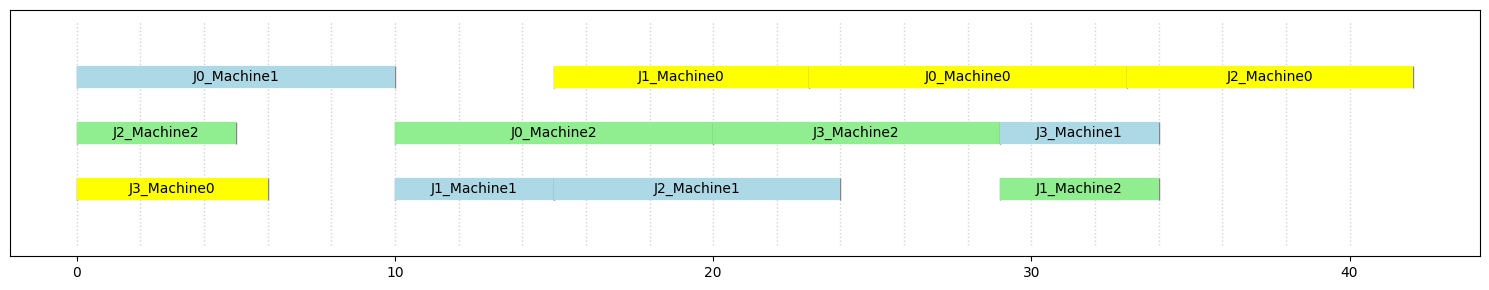

In [9]:
colors = ['yellow', 'lightblue', 'lightgreen', 'red']

for i in DV:
    var_sol = msol.get_var_solution(i)
    machine_id = int(i.name.split('_')[1].replace("Machine",''))
    #visu.panel()
    visu.interval(var_sol, colors[machine_id], i.name, )  
visu.show()

In [10]:
jobs_data['DV_sol'] = jobs_data['DV'].apply(lambda x:msol.get_var_solution(x))
jobs_data['DV_sol_start']=jobs_data['DV_sol'].apply(lambda x:x.get_start())
jobs_data['DV_sol_end']=jobs_data['DV_sol'].apply(lambda x:x.get_end())
jobs_data.sort_values(['DV_sol_start','DV_sol_end'])

,job,machine,duration,order,DV,endtime,DV_sol,DV_sol_start,DV_sol_end
6,J2,2,5,1,"J2_Machine2 = intervalVar(end=0..91, size=5)",endOf(J2_Machine2),"J2_Machine2: (start=0, end=5, size=5, length=5)",0,5
9,J3,0,6,1,"J3_Machine0 = intervalVar(end=0..91, size=6)",endOf(J3_Machine0),"J3_Machine0: (start=0, end=6, size=6, length=6)",0,6
0,J0,1,10,1,"J0_Machine1 = intervalVar(end=0..91, size=10)",endOf(J0_Machine1),"J0_Machine1: (start=0, end=10, size=10, length=10)",0,10
3,J1,1,5,1,"J1_Machine1 = intervalVar(end=0..91, size=5)",endOf(J1_Machine1),"J1_Machine1: (start=10, end=15, size=5, length=5)",10,15
1,J0,2,10,2,"J0_Machine2 = intervalVar(end=0..91, size=10)",endOf(J0_Machine2),"J0_Machine2: (start=10, end=20, size=10, length=10)",10,20
4,J1,0,8,2,"J1_Machine0 = intervalVar(end=0..91, size=8)",endOf(J1_Machine0),"J1_Machine0: (start=15, end=23, size=8, length=8)",15,23
7,J2,1,9,2,"J2_Machine1 = intervalVar(end=0..91, size=9)",endOf(J2_Machine1),"J2_Machine1: (start=15, end=24, size=9, length=9)",15,24
10,J3,2,9,2,"J3_Machine2 = intervalVar(end=0..91, size=9)",endOf(J3_Machine2),"J3_Machine2: (start=20, end=29, size=9, length=9)",20,29
2,J0,0,10,3,"J0_Machine0 = intervalVar(end=0..91, size=10)",endOf(J0_Machine0),"J0_Machine0: (start=23, end=33, size=10, length=10)",23,33
5,J1,2,5,3,"J1_Machine2 = intervalVar(end=0..91, size=5)",endOf(J1_Machine2),"J1_Machine2: (start=29, end=34, size=5, length=5)",29,34


# Example 2

A job shop has four jobs that must be processed on a single machine. The due date and processing time for each job are given in Table 19. Use dynamic programming to
determine the order in which the jobs should be done so as to minimize the total lateness of the jobs. (The lateness of a job is simply how long after the job’s due date the job is completed; for example, if the jobs are processed in the given order, then job 3 will be 2 days late, job 4 will be 4 days late, and jobs 1 and 2 will not be late.)

source : Operations Research, Applications and Algorithms - Wayne Winston

| Job | Processing Time Days)  | Due Data (Date from now) |
|-----|------------------------|--------------------------|
| 1   | 2                      | 4                        |
| 2    |       4                 |   14                       |
|  3   |        6               |       10                   |
|  4   |         8               |       16                   |

In [90]:
mdl = CpoModel(name="JobScheduling")

data = pd.DataFrame( [[1, 2, 4],[2,4,14],[3,6, 10],[4, 8, 16]], columns = ['job','duration', 'due_date'] )
data

,job,duration,due_date
0,1,2,4
1,2,4,14
2,3,6,10
3,4,8,16


In [91]:
horizon = data['duration'].sum()
horizon

20

In [92]:
data['DV']=0
for index, row in data.iterrows():
    dv =  mdl.interval_var((0, horizon) , (0, horizon) , size=row.duration, name="job:{}".format(row.job))
    data.at[index, 'DV']=dv

data

,job,duration,due_date,DV
0,1,2,4,"""job:1"" = intervalVar(start=0..20, end=0..20, size=2)"
1,2,4,14,"""job:2"" = intervalVar(start=0..20, end=0..20, size=4)"
2,3,6,10,"""job:3"" = intervalVar(start=0..20, end=0..20, size=6)"
3,4,8,16,"""job:4"" = intervalVar(start=0..20, end=0..20, size=8)"


In [93]:
# one machine. job shouldn't overlap

mdl.add ( mdl.no_overlap( data['DV'].values.tolist())) 

In [94]:
data['end_date'] = data['DV'].apply(lambda x:mdl.end_of(x))


data['tardiness'] = (data['end_date'] -data['due_date'] ).apply(lambda x:mdl.max(x,0))
data


,job,duration,due_date,DV,end_date,tardiness
0,1,2,4,"""job:1"" = intervalVar(start=0..20, end=0..20, size=2)","endOf(""job:1"")","max(endOf(""job:1"") - 4, 0)"
1,2,4,14,"""job:2"" = intervalVar(start=0..20, end=0..20, size=4)","endOf(""job:2"")","max(endOf(""job:2"") - 14, 0)"
2,3,6,10,"""job:3"" = intervalVar(start=0..20, end=0..20, size=6)","endOf(""job:3"")","max(endOf(""job:3"") - 10, 0)"
3,4,8,16,"""job:4"" = intervalVar(start=0..20, end=0..20, size=8)","endOf(""job:4"")","max(endOf(""job:4"") - 16, 0)"


In [95]:
obj = mdl.minimize( mdl.sum(data['tardiness']))
mdl.add(obj)
msol = mdl.solve(TimeLimit=20)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 5 variables, 1 constraint
 ! TimeLimit            = 20
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 8.0 (before), 8.0 (after)
 !  . Memory usage      : 408.1 kB (before), 408.1 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0          5                 -
 + New bound is 0
 *            16        9  0.02s        1      (gap is 100.0%)
 *            12       17  0.02s        1      (gap is 100.0%)
 *             6       25  0.02s        1      (gap is 100.0%)
 *             4       33  0.02s        1      (gap is 100.0%)
               4       34          4    1   F        -
 + New bound is 4 (gap is 0.00%)
 ! -----------------------------------------------------

In [96]:
data['DV_sol'] = data['DV'].apply(lambda x:msol.get_var_solution(x))
data['DV_sol_start']=data['DV_sol'].apply(lambda x:x.get_start())
data['DV_sol_end']=data['DV_sol'].apply(lambda x:x.get_end())

data['tardiness_sol'] =  (data['DV_sol_end'] -data['due_date'] ).apply(lambda x:max(x,0))
data.sort_values(['DV_sol_start','DV_sol_end'])

,job,duration,due_date,DV,end_date,tardiness,DV_sol,DV_sol_start,DV_sol_end,tardiness_sol
0,1,2,4,"""job:1"" = intervalVar(start=0..20, end=0..20, size=2)","endOf(""job:1"")","max(endOf(""job:1"") - 4, 0)","job:1: (start=0, end=2, size=2, length=2)",0,2,0
2,3,6,10,"""job:3"" = intervalVar(start=0..20, end=0..20, size=6)","endOf(""job:3"")","max(endOf(""job:3"") - 10, 0)","job:3: (start=2, end=8, size=6, length=6)",2,8,0
1,2,4,14,"""job:2"" = intervalVar(start=0..20, end=0..20, size=4)","endOf(""job:2"")","max(endOf(""job:2"") - 14, 0)","job:2: (start=8, end=12, size=4, length=4)",8,12,0
3,4,8,16,"""job:4"" = intervalVar(start=0..20, end=0..20, size=8)","endOf(""job:4"")","max(endOf(""job:4"") - 16, 0)","job:4: (start=12, end=20, size=8, length=8)",12,20,4


In [100]:
from docplex.cp.utils import CpoNotSupportedException

siter = mdl.start_search(SearchType='DepthFirst', Workers=1, TimeLimit=10, log_output = None) # Parameters needed to avoid duplicate solutions
try:
    for i, msol in enumerate(siter):
        print("Solution_"+str(i + 1) + ": ")
        

        data['DV_sol'] = data['DV'].apply(lambda x:msol.get_var_solution(x))
        data['DV_sol_start']=data['DV_sol'].apply(lambda x:x.get_start())
        data['DV_sol_end']=data['DV_sol'].apply(lambda x:x.get_end())
        data['tardiness_sol'] =  (data['DV_sol_end'] -data['due_date'] ).apply(lambda x:max(x,0))
        data = data.sort_values(['DV_sol_start','DV_sol_end'])
        #display(data)

        print(data['job'].values , 'tardiness =', data['tardiness_sol'].sum())

        #if data['job'].values.tolist() == [4,2,3,1]:
            #display(data)
        
except CpoNotSupportedException:
    print("This instance of the solver does not support solution iteration.")

Solution_1: 
[4 2 3 1] tardiness = 24
Solution_2: 
[4 2 1 3] tardiness = 20
Solution_3: 
[4 1 2 3] tardiness = 16
Solution_4: 
[1 2 3 4] tardiness = 6
Solution_5: 
[1 3 2 4] tardiness = 4


# Example 3

source: Ronald l. RaRdin  - Optimization in Operations Research - 2016

job shop scheduling with a fictitious Custom Metalworking company
which fabricates prototype metal parts for a nearby engine manufacturer.
Figure 11.9 provides details on the 3 jobs waiting to be scheduled. First is a die
requiring work on a sequence of 5 workstations: 1 (forging), then 2 (machining),
then 3 (grinding), then 4 (polishing), and finally, 6 (electric discharge cutting). Job
2 is a cam shaft requiring 4 stations, and job 3 a fuel injector requiring 5 steps.
Numbers in boxes indicate process times

$p_{j,k}$ = process time (in minutes) of job j on processor k

assume that the company wants to complete
all 3 jobs as soon as possible (minimize maximum completion), so that workers
can leave for a holiday.

![](../pics/2023-08-03-10-06-51.png)


In [3]:
data = [['Die','1','WS1',3],['Die','2','WS2',10],['Die','3','WS3',8],['Die','4','WS4',45],['Die','5','WS6',1] ,
        ['Camshaft','1','WS7',50],['Camshaft','2','WS1',6],['Camshaft','3','WS2',11],['Camshaft','4','WS3',6],
        ['FuelInjector','1','WS2',5],['FuelInjector','2','WS3',9],['FuelInjector','3','WS5',2],['FuelInjector','4','WS6',1],['FuelInjector','5','WS4',25]
        ]

data = pd.DataFrame(data, columns = ['type','job','workstation','duration'])
data

,type,job,workstation,duration
0,Die,1,WS1,3
1,Die,2,WS2,10
2,Die,3,WS3,8
3,Die,4,WS4,45
4,Die,5,WS6,1
5,Camshaft,1,WS7,50
6,Camshaft,2,WS1,6
7,Camshaft,3,WS2,11
8,Camshaft,4,WS3,6
9,FuelInjector,1,WS2,5


In [4]:
horizon = data['duration'].sum()

In [5]:
mdl = CpoModel(name="JobScheduling")


data['DV']=0
for index, row in data.iterrows():
    dv =  mdl.interval_var((0, horizon) , (0, horizon) , size=row.duration, name="{}:{}:{}".format(row.type, row.job, row.workstation))
    data.at[index, 'DV']=dv

data.head(2)

,type,job,workstation,duration,DV
0,Die,1,WS1,3,"""Die:1:WS1"" = intervalVar(start=0..182, end=0..182, size=3)"
1,Die,2,WS2,10,"""Die:2:WS2"" = intervalVar(start=0..182, end=0..182, size=10)"


In [6]:
# precedence
Types = data['type'].unique()

for type in Types:

    u = data[data['type']==type]
    m = len(u)

    precedence_list = [[i,i+1] for i in range(1,m+1)][:-1]
    for i in precedence_list:
        first_task = u[u['job']==str(i[0])]['DV'].values[0]
        second_task = u[u['job']==str(i[1])]['DV'].values[0]
        print( first_task,second_task )
        mdl.add( mdl.end_before_start(first_task  , second_task ))

"Die:1:WS1" = intervalVar(start=0..182, end=0..182, size=3) "Die:2:WS2" = intervalVar(start=0..182, end=0..182, size=10)
"Die:2:WS2" = intervalVar(start=0..182, end=0..182, size=10) "Die:3:WS3" = intervalVar(start=0..182, end=0..182, size=8)
"Die:3:WS3" = intervalVar(start=0..182, end=0..182, size=8) "Die:4:WS4" = intervalVar(start=0..182, end=0..182, size=45)
"Die:4:WS4" = intervalVar(start=0..182, end=0..182, size=45) "Die:5:WS6" = intervalVar(start=0..182, end=0..182, size=1)
"Camshaft:1:WS7" = intervalVar(start=0..182, end=0..182, size=50) "Camshaft:2:WS1" = intervalVar(start=0..182, end=0..182, size=6)
"Camshaft:2:WS1" = intervalVar(start=0..182, end=0..182, size=6) "Camshaft:3:WS2" = intervalVar(start=0..182, end=0..182, size=11)
"Camshaft:3:WS2" = intervalVar(start=0..182, end=0..182, size=11) "Camshaft:4:WS3" = intervalVar(start=0..182, end=0..182, size=6)
"FuelInjector:1:WS2" = intervalVar(start=0..182, end=0..182, size=5) "FuelInjector:2:WS3" = intervalVar(start=0..182, end=0

In [7]:
# workstations are allocated to one job at a time

jobs_same_workstation = data[['workstation','DV']].groupby('workstation').agg(list).reset_index(drop=False)

display(jobs_same_workstation)

for row in jobs_same_workstation.itertuples():
    mdl.add ( mdl.no_overlap(  row.DV ))

,workstation,DV
0,WS1,"[""Die:1:WS1"" = intervalVar(start=0..182, end=0..182, size=3), ""Camshaft:2:WS1"" = intervalVar(start=0..182, end=0..182, size=6)]"
1,WS2,"[""Die:2:WS2"" = intervalVar(start=0..182, end=0..182, size=10), ""Camshaft:3:WS2"" = intervalVar(start=0..182, end=0..182, size=11), ""FuelInjector:1:WS2"" = intervalVar(start=0..182, end=0..182, size=5)]"
2,WS3,"[""Die:3:WS3"" = intervalVar(start=0..182, end=0..182, size=8), ""Camshaft:4:WS3"" = intervalVar(start=0..182, end=0..182, size=6), ""FuelInjector:2:WS3"" = intervalVar(start=0..182, end=0..182, size=9)]"
3,WS4,"[""Die:4:WS4"" = intervalVar(start=0..182, end=0..182, size=45), ""FuelInjector:5:WS4"" = intervalVar(start=0..182, end=0..182, size=25)]"
4,WS5,"[""FuelInjector:3:WS5"" = intervalVar(start=0..182, end=0..182, size=2)]"
5,WS6,"[""Die:5:WS6"" = intervalVar(start=0..182, end=0..182, size=1), ""FuelInjector:4:WS6"" = intervalVar(start=0..182, end=0..182, size=1)]"
6,WS7,"[""Camshaft:1:WS7"" = intervalVar(start=0..182, end=0..182, size=50)]"


In [8]:
data.loc[:,'endtime']=data['DV'].apply(lambda x:mdl.end_of(x))

obj = mdl.minimize ( mdl.max ( data['endtime']) )

mdl.add(obj)

msol = mdl.solve(TimeLimit=50)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 21 variables, 18 constraints
 ! TimeLimit            = 50
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 53.3 (before), 53.3 (after)
 !  . Memory usage      : 474.2 kB (before), 474.2 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         21                 -
 + New bound is 73
 ! Using iterative diving.
 *            88       29  0.03s        1      (gap is 17.05%)
              88       30         16    1   F        -
 + New bound is 88 (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! Best objective         : 88 (optimal - effective tol. is 0)
 ! Best bound             : 8

In [12]:
data['DV_sol'] = data['DV'].apply(lambda x:msol.get_var_solution(x))
data['DV_sol_start']=data['DV_sol'].apply(lambda x:x.get_start())
data['DV_sol_end']=data['DV_sol'].apply(lambda x:x.get_end())

data.sort_values(['DV_sol_start','DV_sol_end'])

,type,job,workstation,duration,DV,endtime,DV_sol,DV_sol_start,DV_sol_end
0,Die,1,WS1,3,"""Die:1:WS1"" = intervalVar(start=0..182, end=0..182, size=3)","endOf(""Die:1:WS1"")","Die:1:WS1: (start=0, end=3, size=3, length=3)",0,3
9,FuelInjector,1,WS2,5,"""FuelInjector:1:WS2"" = intervalVar(start=0..182, end=0..182, size=5)","endOf(""FuelInjector:1:WS2"")","FuelInjector:1:WS2: (start=0, end=5, size=5, length=5)",0,5
5,Camshaft,1,WS7,50,"""Camshaft:1:WS7"" = intervalVar(start=0..182, end=0..182, size=50)","endOf(""Camshaft:1:WS7"")","Camshaft:1:WS7: (start=0, end=50, size=50, length=50)",0,50
10,FuelInjector,2,WS3,9,"""FuelInjector:2:WS3"" = intervalVar(start=0..182, end=0..182, size=9)","endOf(""FuelInjector:2:WS3"")","FuelInjector:2:WS3: (start=5, end=14, size=9, length=9)",5,14
1,Die,2,WS2,10,"""Die:2:WS2"" = intervalVar(start=0..182, end=0..182, size=10)","endOf(""Die:2:WS2"")","Die:2:WS2: (start=5, end=15, size=10, length=10)",5,15
11,FuelInjector,3,WS5,2,"""FuelInjector:3:WS5"" = intervalVar(start=0..182, end=0..182, size=2)","endOf(""FuelInjector:3:WS5"")","FuelInjector:3:WS5: (start=14, end=16, size=2, length=2)",14,16
2,Die,3,WS3,8,"""Die:3:WS3"" = intervalVar(start=0..182, end=0..182, size=8)","endOf(""Die:3:WS3"")","Die:3:WS3: (start=15, end=23, size=8, length=8)",15,23
12,FuelInjector,4,WS6,1,"""FuelInjector:4:WS6"" = intervalVar(start=0..182, end=0..182, size=1)","endOf(""FuelInjector:4:WS6"")","FuelInjector:4:WS6: (start=16, end=17, size=1, length=1)",16,17
13,FuelInjector,5,WS4,25,"""FuelInjector:5:WS4"" = intervalVar(start=0..182, end=0..182, size=25)","endOf(""FuelInjector:5:WS4"")","FuelInjector:5:WS4: (start=17, end=42, size=25, length=25)",17,42
3,Die,4,WS4,45,"""Die:4:WS4"" = intervalVar(start=0..182, end=0..182, size=45)","endOf(""Die:4:WS4"")","Die:4:WS4: (start=42, end=87, size=45, length=45)",42,87


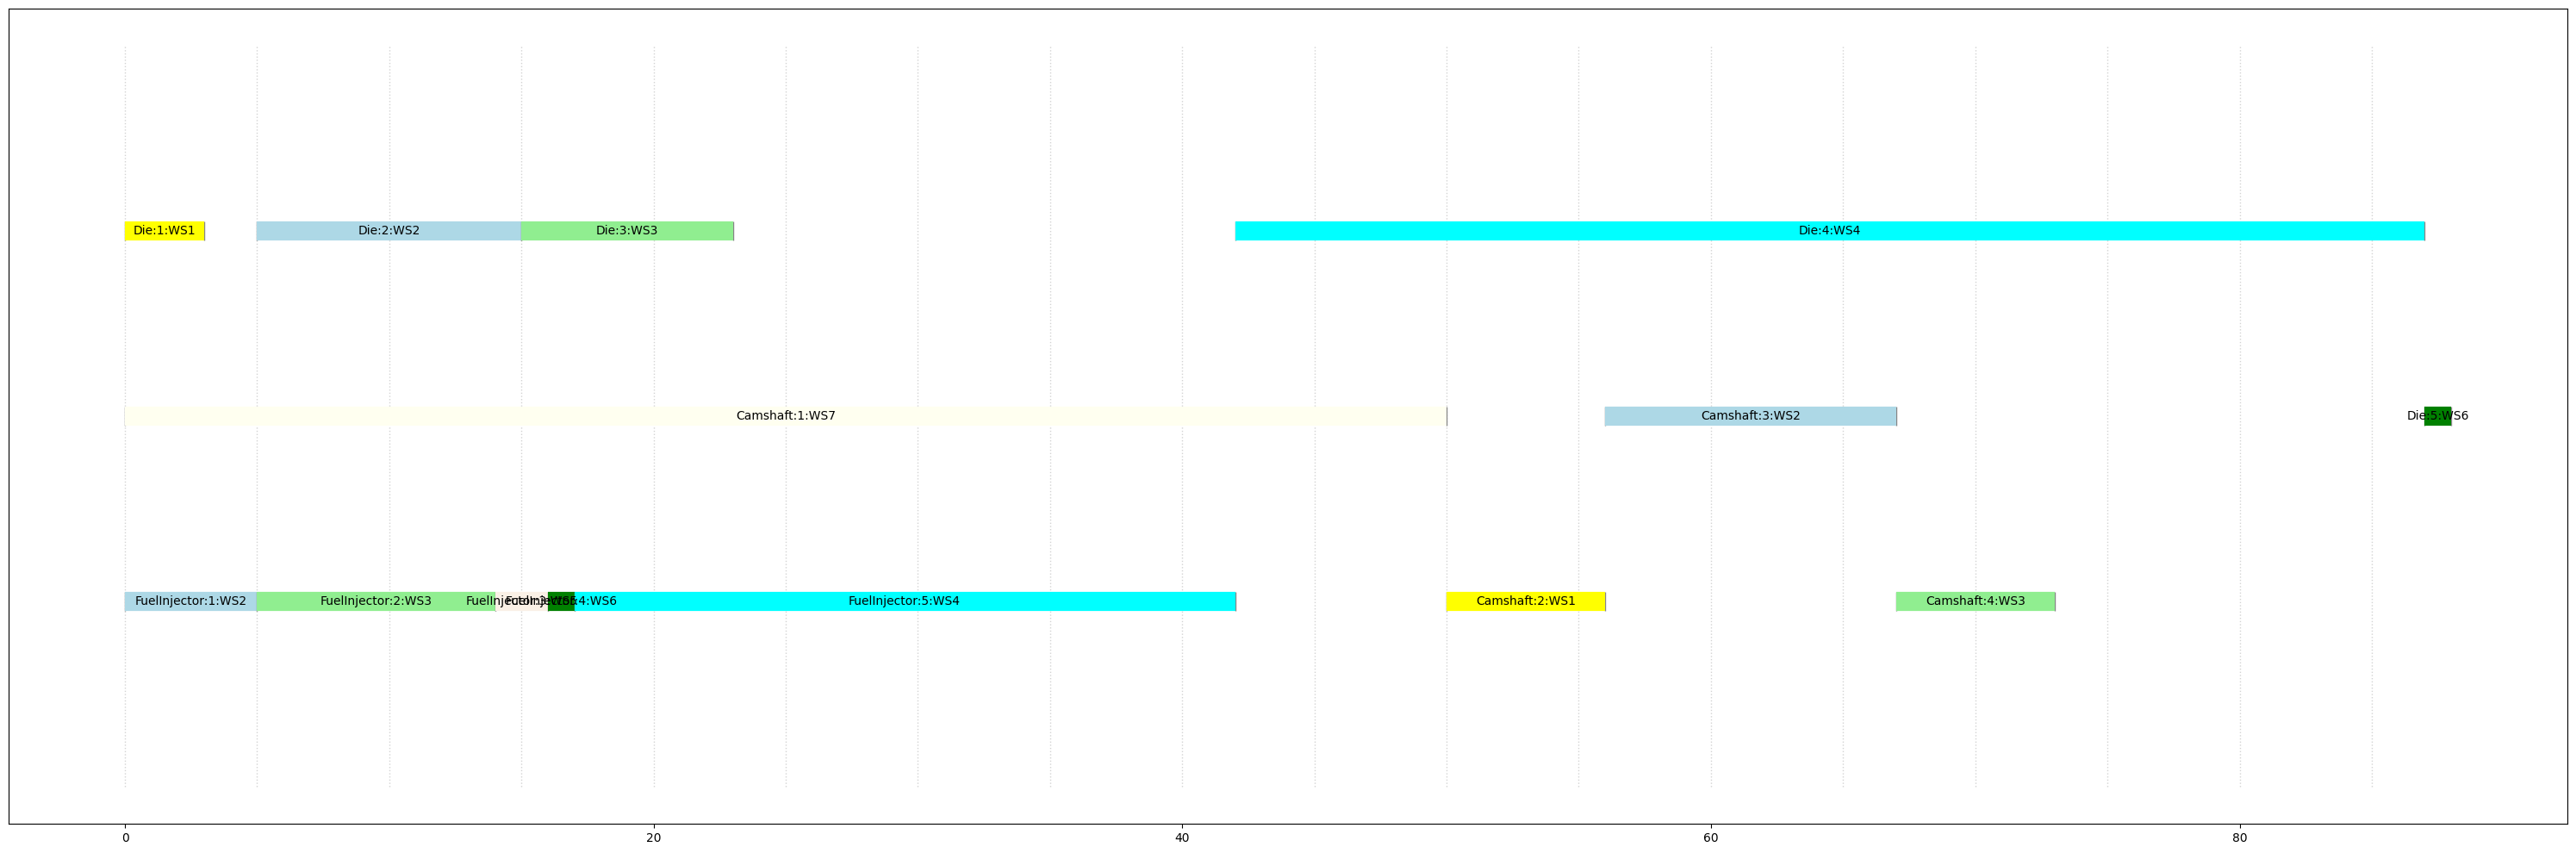

In [15]:
#colors ={"Die":'yellow',   "Camshaft":'lightblue',"FuelInjector":'linen'}
colors ={"WS1":'yellow',   "WS2":'lightblue', "WS3":  'lightgreen',"WS4" :'cyan' ,"WS5":'linen',"WS6":'green',"WS7":'ivory'}
rcParams['figure.figsize'] = 30, 10

for i in data['DV'].values:
    wt = msol.get_var_solution(i)
    type = wt.get_name().split(':')[0]
    job = wt.get_name().split(':')[1]
    wstation = wt.get_name().split(':')[2]  

    visu.interval(wt, colors[wstation], ':'.join([type, job, wstation])) 

visu.show()


# Example 4

We consider the 4-job, single machine problem with deadlines. minimize the weighted completion time, such that the deadlines are met.

source: Introduction to Linear Optimization, Dimitris Bertsimas

| Job | 1  | 2 | 3  | 4 |
|-----|-----|-----|-----|-----|
| duration   | 2   | 6     |8  | 11
| deadline    |       10               |  28     | 29 | 30 |
|  weight   |        0.5               |       2     | 3 | 4 |


In [232]:
data = pd.DataFrame([[1,2,10,0.5],[2,6,28,2],[3,8,29,3],[4,11,30,4]])
data.columns = ['job','duration','deadline','weight']
data


,job,duration,deadline,weight
0,1,2,10,0.5
1,2,6,28,2.0
2,3,8,29,3.0
3,4,11,30,4.0


In [233]:
mdl = CpoModel()
for index, row in data.iterrows():
    dv =  mdl.interval_var( (0, int(row.deadline)) , (0, int(row.deadline)) , size=int(row.duration), name="job:{}".format(row.job))
    data.at[index, 'DV']=dv
data

,job,duration,deadline,weight,DV
0,1,2,10,0.5,"""job:1.0"" = intervalVar(start=0..10, end=0..10, size=2)"
1,2,6,28,2.0,"""job:2.0"" = intervalVar(start=0..28, end=0..28, size=6)"
2,3,8,29,3.0,"""job:3.0"" = intervalVar(start=0..29, end=0..29, size=8)"
3,4,11,30,4.0,"""job:4.0"" = intervalVar(start=0..30, end=0..30, size=11)"


In [234]:
# one machine. job shouldn't overlap

mdl.add ( mdl.no_overlap( data['DV'].values.tolist())) 

In [235]:
data['end']=data['DV'].apply(lambda x:mdl.end_of(x))
data

,job,duration,deadline,weight,DV,end
0,1,2,10,0.5,"""job:1.0"" = intervalVar(start=0..10, end=0..10, size=2)","endOf(""job:1.0"")"
1,2,6,28,2.0,"""job:2.0"" = intervalVar(start=0..28, end=0..28, size=6)","endOf(""job:2.0"")"
2,3,8,29,3.0,"""job:3.0"" = intervalVar(start=0..29, end=0..29, size=8)","endOf(""job:3.0"")"
3,4,11,30,4.0,"""job:4.0"" = intervalVar(start=0..30, end=0..30, size=11)","endOf(""job:4.0"")"


In [236]:
obj = mdl.minimize( mdl.sum( data['weight'] * data['end']))
mdl.add(obj)
msol = mdl.solve(TimeLimit=30, trace_log=False)

In [237]:
data['DV_sol'] = data['DV'].apply(lambda x:msol.get_var_solution(x))
data['DV_sol_start']=data['DV_sol'].apply(lambda x:x.get_start())
data['DV_sol_end']=data['DV_sol'].apply(lambda x:x.get_end())

data

,job,duration,deadline,weight,DV,end,DV_sol,DV_sol_start,DV_sol_end
0,1,2,10,0.5,"""job:1.0"" = intervalVar(start=0..10, end=0..10, size=2)","endOf(""job:1.0"")","job:1.0: (start=8, end=10, size=2, length=2)",8,10
1,2,6,28,2.0,"""job:2.0"" = intervalVar(start=0..28, end=0..28, size=6)","endOf(""job:2.0"")","job:2.0: (start=21, end=27, size=6, length=6)",21,27
2,3,8,29,3.0,"""job:3.0"" = intervalVar(start=0..29, end=0..29, size=8)","endOf(""job:3.0"")","job:3.0: (start=0, end=8, size=8, length=8)",0,8
3,4,11,30,4.0,"""job:4.0"" = intervalVar(start=0..30, end=0..30, size=11)","endOf(""job:4.0"")","job:4.0: (start=10, end=21, size=11, length=11)",10,21


# Example 5

what is minumum time to finish these tasks?

source: Introduction to Operations Research, Hillier; Lieberman

![](../pics/2023-08-04-22-05-26.png)

In [287]:
data = pd.DataFrame([])
data['activity'] =['A','B','C','D','E','F','G','H','I','J','K','L','M','N' ]
data['predecessor'] = [ [],'A','B','C','C','E','D',['E','G'],'C',['F','I'],'J','J','H',['K','L']]
data['duration']=[2,4,10,6,4,5,7,9,7,8,4,5,2,6]

data

,activity,predecessor,duration
0,A,[],2
1,B,A,4
2,C,B,10
3,D,C,6
4,E,C,4
5,F,E,5
6,G,D,7
7,H,"[E, G]",9
8,I,C,7
9,J,"[F, I]",8


In [288]:
mdl = CpoModel()
horizon = data['duration'].sum()

data['DV']=0
for index, row in data.iterrows():
    dv =  mdl.interval_var((0, horizon) , (0, horizon) , size=row.duration, name="Act:{}".format(row.activity))
    data.at[index, 'DV']=dv

data.head(2)


,activity,predecessor,duration,DV
0,A,[],2,"""Act:A"" = intervalVar(start=0..79, end=0..79, size=2)"
1,B,A,4,"""Act:B"" = intervalVar(start=0..79, end=0..79, size=4)"


In [289]:
data['endtime']=data['DV'].apply(lambda x:mdl.end_of(x))
data.head()

,activity,predecessor,duration,DV,endtime
0,A,[],2,"""Act:A"" = intervalVar(start=0..79, end=0..79, size=2)","endOf(""Act:A"")"
1,B,A,4,"""Act:B"" = intervalVar(start=0..79, end=0..79, size=4)","endOf(""Act:B"")"
2,C,B,10,"""Act:C"" = intervalVar(start=0..79, end=0..79, size=10)","endOf(""Act:C"")"
3,D,C,6,"""Act:D"" = intervalVar(start=0..79, end=0..79, size=6)","endOf(""Act:D"")"
4,E,C,4,"""Act:E"" = intervalVar(start=0..79, end=0..79, size=4)","endOf(""Act:E"")"


In [290]:
for row in data.itertuples():
    pred = row.predecessor
    if isinstance(pred, str):
        pred = [pred]

    for j in pred:
        pred_dv = data[data['activity']==j]['DV'].values[0]
        #print( pred_dv, row.DV)
        mdl.add( mdl.end_before_start(pred_dv, row.DV))

In [291]:
obj = mdl.minimize ( mdl.max ( data['endtime']) )
mdl.add(obj)
msol = mdl.solve(TimeLimit=30, trace_log=False)

msol.get_objective_values()

(44,)

In [292]:
data['DV_sol'] = data['DV'].apply(lambda x:msol.get_var_solution(x))
data['DV_sol_start']=data['DV_sol'].apply(lambda x:x.get_start())
data['DV_sol_end']=data['DV_sol'].apply(lambda x:x.get_end())

data.sort_values('DV_sol_start')

,activity,predecessor,duration,DV,endtime,DV_sol,DV_sol_start,DV_sol_end
0,A,[],2,"""Act:A"" = intervalVar(start=0..79, end=0..79, size=2)","endOf(""Act:A"")","Act:A: (start=0, end=2, size=2, length=2)",0,2
1,B,A,4,"""Act:B"" = intervalVar(start=0..79, end=0..79, size=4)","endOf(""Act:B"")","Act:B: (start=2, end=6, size=4, length=4)",2,6
2,C,B,10,"""Act:C"" = intervalVar(start=0..79, end=0..79, size=10)","endOf(""Act:C"")","Act:C: (start=6, end=16, size=10, length=10)",6,16
3,D,C,6,"""Act:D"" = intervalVar(start=0..79, end=0..79, size=6)","endOf(""Act:D"")","Act:D: (start=16, end=22, size=6, length=6)",16,22
4,E,C,4,"""Act:E"" = intervalVar(start=0..79, end=0..79, size=4)","endOf(""Act:E"")","Act:E: (start=16, end=20, size=4, length=4)",16,20
8,I,C,7,"""Act:I"" = intervalVar(start=0..79, end=0..79, size=7)","endOf(""Act:I"")","Act:I: (start=16, end=23, size=7, length=7)",16,23
5,F,E,5,"""Act:F"" = intervalVar(start=0..79, end=0..79, size=5)","endOf(""Act:F"")","Act:F: (start=20, end=25, size=5, length=5)",20,25
6,G,D,7,"""Act:G"" = intervalVar(start=0..79, end=0..79, size=7)","endOf(""Act:G"")","Act:G: (start=22, end=29, size=7, length=7)",22,29
9,J,"[F, I]",8,"""Act:J"" = intervalVar(start=0..79, end=0..79, size=8)","endOf(""Act:J"")","Act:J: (start=25, end=33, size=8, length=8)",25,33
7,H,"[E, G]",9,"""Act:H"" = intervalVar(start=0..79, end=0..79, size=9)","endOf(""Act:H"")","Act:H: (start=29, end=38, size=9, length=9)",29,38
